# Phylogeographic Temporal Analysis

PTA is what you get when you put a bunch of momi and dadi inference together.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import ipyparallel as ipp
import matplotlib.pyplot as plt
import momi
import numpy as np
import os
import pandas as pd
import time

from IPython.display import display

import PTA


In [2]:
# ipcluster start --n=4 --cluster-id="PTA" --daemonize
ipyclient = ipp.Client(cluster_id="PTA")
len(ipyclient)

4

# Simulate
Make a simple demographic model, plot the default parameters and generate a couple quick simulations.

In [3]:
model = PTA.DemographicModel("watdo")
print(model.get_params())
msfs_list = model.serial_simulate(nsims=2, quiet=False, verbose=False)

------- PTA params file (v.0.0.9)-----------------------------------------------
watdo                ## [0] [simulation_name]: The name of this simulation scenario
./default_PTA        ## [1] [project_dir]: Where to save files
10                   ## [2] [npops]: Number of populations undergoing co-demographic processes
4                    ## [3] [nsamps]: Numbers of samples for each populations
                     ## [4] [N_e]: Effective population size of the ancestral population
                     ## [5] [tau]: Time of demographic change
                     ## [6] [epsilon]: Magnitude of demographic change
1000                 ## [7] [length]: Length in bp of each indpendent genomic region to simulate
100                  ## [8] [num_replicates]: Number of genomic regions to simulate
1e-09                ## [9] [recoms_per_gen]: Recombination rate within independent regions scaled per base per generation
1e-08                ## [10] [muts_per_gen]: Mutation rate scaled per bas

# Look at the results
Look at some pre-baked simulation results. Here the only "parameters" so far are zeta (proportion of co-expanding taxa) and psi (number of co-expansion pulses).

There's an internal switch to enable/disable multiple coexpansion events, and here you can see for these simulations that it was enabled (psi can take values > 1). The rest of all the output are the SFS bins in momi format.

In [41]:
sim_df = pd.read_csv("../PTA/default_PTA/10samps_loci-SIMOUT.csv", sep=" ")
sim_df.head()

,pop0-[[1_9]],pop0-[[2_8]],pop0-[[3_7]],pop0-[[4_6]],pop0-[[5_5]],pop0-[[6_4]],pop0-[[7_3]],pop0-[[8_2]],pop0-[[9_1]],pop1-[[1_9]],...,pop9-[[2_8]],pop9-[[3_7]],pop9-[[4_6]],pop9-[[5_5]],pop9-[[6_4]],pop9-[[7_3]],pop9-[[8_2]],pop9-[[9_1]],psi,zeta
0,0.0,2.0,1.0,1,0,1,2,9,69,1.0,...,1.0,0.0,0,1,1,2,9,85,1,0.606
1,0.0,0.0,2.0,0,0,0,4,12,85,1.0,...,1.0,0.0,0,0,0,4,12,82,1,0.932
2,1.0,0.0,0.0,1,2,1,4,5,77,0.0,...,0.0,0.0,1,1,1,1,10,84,1,0.736
3,0.0,0.0,0.0,1,0,1,2,13,113,0.0,...,0.0,0.0,0,1,0,2,12,79,1,0.797
4,1.0,0.0,0.0,0,0,0,3,3,79,0.0,...,0.0,0.0,0,1,3,4,6,73,1,0.398


# Some simple plotting routines
You can plot the mSFS on the first two PCs. The 'target' parameter specifies whether to color the points by 'psi' or by 'zeta' values.

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

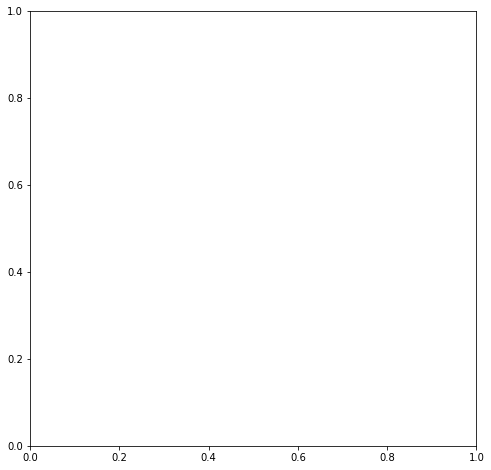

In [48]:
sim_df = pd.read_csv("../PTA/default_PTA/10samps_loci-SIMOUT.csv", sep=" ").head(500)
PTA.plotting.plot_simulations_pca(sim_df, target="psi")

You can also plot histograms of all the parameters. This is kind of like the "priors".

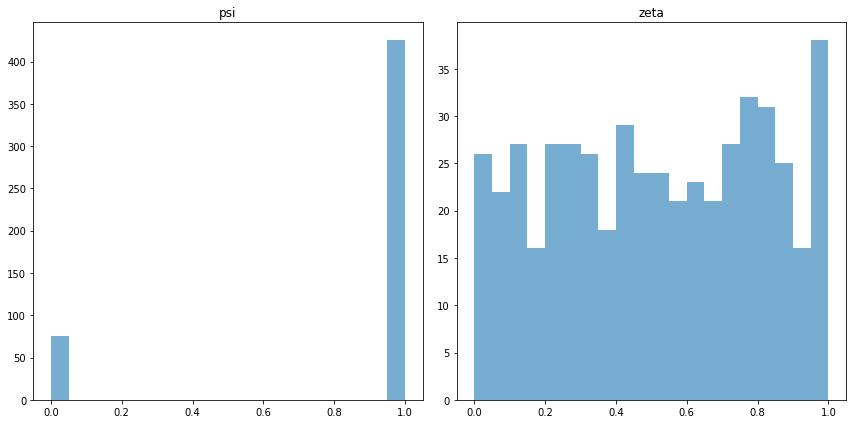

In [39]:
axs = PTA.plotting.plot_simulations_hist(sim_df)

# ML Inference
Now comes the fun part. 
## Prep the data


In [32]:
## Prep the data
## Just take the first one as the pseudo-observed data
true_parameters = pd.DataFrame(sim_df.loc[0]).T[["zeta", "psi"]]
empirical_df = pd.DataFrame(sim_df.loc[0]).T.drop(["zeta", "psi"], axis=1)
display(empirical_df)
tmp_df = sim_df.drop([0])
print(true_parameters)

,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],pop2-[[3_1]],pop3-[[1_3]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
0,12.0,23.0,27.0,18.0,19.0,24.0,11.0,22.0,43.0,5.0,...,53.0,11.0,12.0,26.0,15.0,27.0,51.0,12.0,13.0,34.0


    zeta  psi
0  0.333  1.0


# Cross-validation on classification of Psi
In that psi is _kind of_ ordinal data, we can do model classification cross-validation. This will do by default 5-fold cross-validation, but you can tune that if you want.

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/isaac/PTA/PTA/inference.py:375: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_model.fit(self.X, self.y)
/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


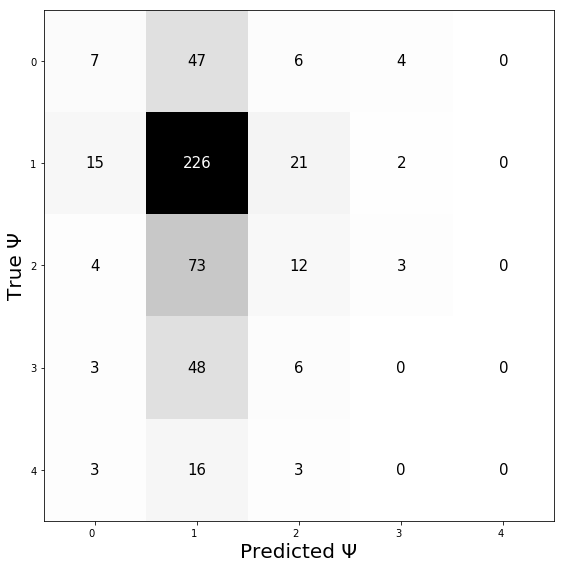

In [35]:
cla = PTA.inference.classification_cv(sim_df)
ax = cla.plot_confusion_matrix()

# Cross-validation on estimation of parameters
Here we can do 5-fold cross validation on parameter estimation. Whether psi is a 'model' or a 'parameter' is somewhat arguable, probably it's a 'model' because fractional psi values don't make sense.

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


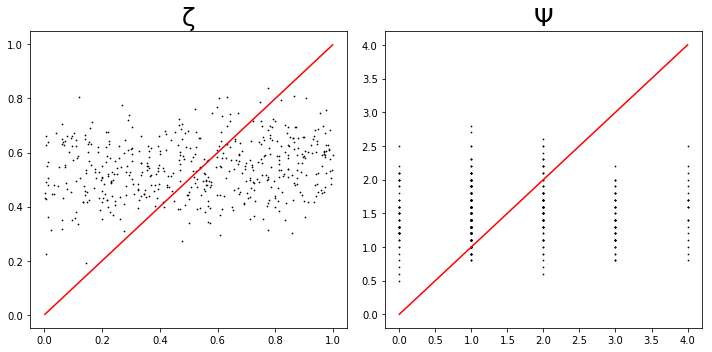

In [36]:
cla = PTA.inference.parameter_estimation_cv(sim_df)
ax = cla.plot_cv_predictions(figdims=(1,2))

# Perform Psi classification
Now this is classic model selection. We're using just one random simulation peeled off from the pack as the pseudo-observed data.

In [30]:
cla = PTA.inference.Classifier(empirical_df=empirical_df, sims=tmp_df, verbose=False)
est, proba = cla.predict(select_features=False, param_search=False, quick=True, verbose=True)

Predict() started: 2019-10-02 11:05:53.782787
Predict() finished: 2019-10-02 11:05:53.909667


/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/isaac/PTA/PTA/inference.py:375: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_model.fit(self.X, self.y)


## Look at classification results
Here we show the true 'known' psi, the estimate, and probability weights. We can also examine the feature importances, which show whether there are any mSFS bins that contribute more to information on psi.

'True psi 1.0'

,psi
estimate,3


,0,1,2,3,4
psi,0.1,0.3,0.2,0.4,0.0


,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],pop2-[[3_1]],pop3-[[1_3]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
Feature importance,0.035303,0.034631,0.036772,0.045525,0.02755,0.032227,0.024572,0.038946,0.034886,0.032323,...,0.031216,0.018681,0.024198,0.030945,0.032812,0.03308,0.055254,0.037195,0.038322,0.032474


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08845745f8>]],
      dtype=object)

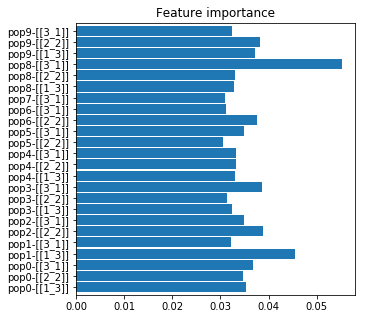

In [36]:
display("True psi = {}".format(true_parameters["psi"].values[0]), est, proba)
display(cla.feature_importances())
cla.plot_feature_importance(figsize=(5,5), cutoff=0.03)

# Perform ML Regression for parameter estimation
Now this is classic parameter estimation. We're using the same random simulation peeled off from the pack as the pseudo-observed data.

In [37]:
rgr = PTA.inference.Regressor(empirical_df=empirical_df, sims=tmp_df)
est = rgr.predict(select_features=False, param_search=False, quick=True, verbose=False)

In [38]:
print(true_parameters)
display(est)

    zeta  psi
0  0.333  1.0


,zeta,psi
estimate,0.5149,1.1
lower 0.025,0.0270,0.0
upper 0.975,0.9680,3.0


## Plot feature importance
Again we can look at feature importances and here, for whatever reason, a couple of the mSFS bins are contributing more information during the regression. It's probably just noise, so don't try to read too much into it.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0884441550>],
      dtype=object)

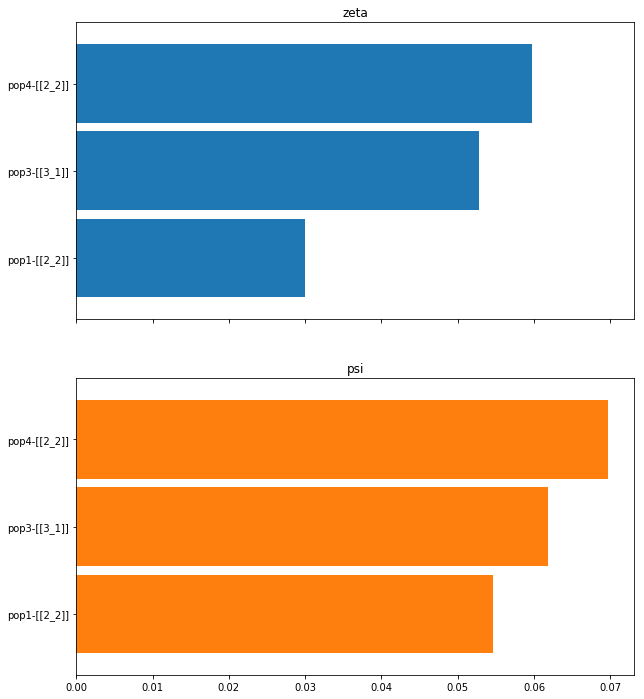

In [39]:
rgr.plot_feature_importance()

# Trash below here

# Build a demographic model

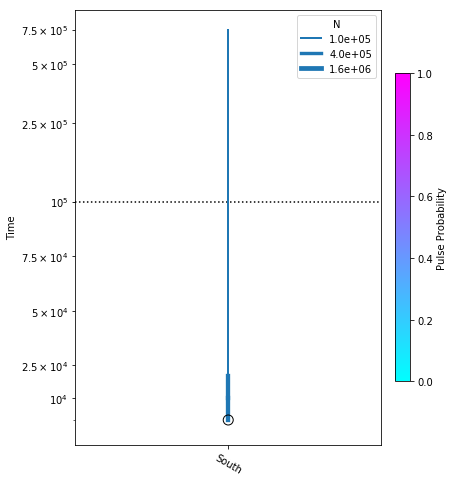

In [33]:
model = momi.DemographicModel(N_e=1e6)
model.add_leaf("South")
#model.add_time_param("texp")
model.set_size("South", t=20000, N=1e5)

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, 
    ["South"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5)

In [1069]:
## Simulated empirical

def get_sfs(name, N_e=1e6, t=20000, exp_magnitude=10, verbose=False):
    model = momi.DemographicModel(N_e=N_e)
    model.add_leaf(name)
    model.set_size(name, t=t, N=N_e/exp_magnitude)
    sampled_n_dict={name:4}
    if verbose: print(sampled_n_dict)
    ac = model.simulate_data(length=100,
                            num_replicates=100,
                            recoms_per_gen=1e-9,
                            muts_per_gen=1e-8,
                            sampled_n_dict=sampled_n_dict)
    return ac.extract_sfs(n_blocks=1)

south_sfs = get_sfs("South")
north_sfs = get_sfs("North")
central_sfs = get_sfs("Central", exp_magnitude=1)
np.array([south_sfs.loc_counts, central_sfs.loc_counts, north_sfs.loc_counts])

array([[[  9.,  51.,  15.]],

       [[378., 122., 220.]],

       [[ 21.,  54.,  13.]]])

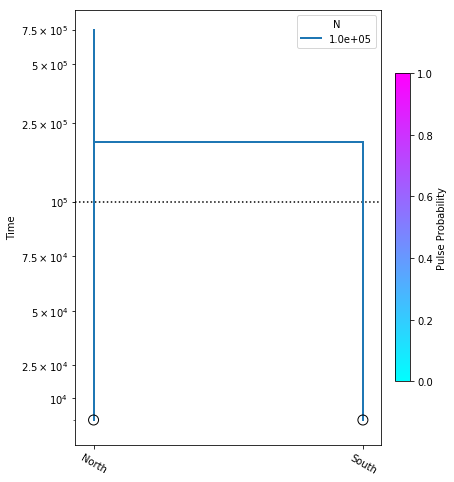

In [3]:
model = momi.DemographicModel(N_e=1e5)
model.add_leaf("North")
model.add_leaf("South")
model.move_lineages("South", "North", t=2e5)

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, 
    ["North", "South"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5)

In [13]:
sampled_n_dict={"North":4, "South":4}
ac = model.simulate_data(length=100,
                    num_replicates=1000,
                    recoms_per_gen=1e-9,
                    muts_per_gen=1e-8,
                    sampled_n_dict=sampled_n_dict)

In [3]:
model = PTA.DemographicModel("watdo")


In [49]:
pd.read_csv("../PTA/default_PTA/10samps_1000loci-SIMOUT.csv", sep=" ")

,zeta,psi,t_s,omega,taus_mean,taus_std,taus_skewness,taus_kurtosis,taus_median,taus_iqr,...,pop8-[[9_1]],pop9-[[1_9]],pop9-[[2_8]],pop9-[[3_7]],pop9-[[4_6]],pop9-[[5_5]],pop9-[[6_4]],pop9-[[7_3]],pop9-[[8_2]],pop9-[[9_1]]
0,0.675,1,1000,0,1000.0,0.0,0.0,-3.0,1000.0,0.0,...,118,2,6,3,12,7,7,10,22,118
1,0.297,1,1000,0,1000.0,0.0,0.0,-3.0,1000.0,0.0,...,107,4,7,8,2,7,7,12,19,105
2,0.500,1,1000,0,1000.0,0.0,0.0,-3.0,1000.0,0.0,...,102,1,2,4,7,6,11,8,33,124
3,0.500,1,1000,0,1000.0,0.0,0.0,-3.0,1000.0,0.0,...,122,5,9,4,5,11,8,9,25,118


In [72]:
model = PTA.DemographicModel("watdo")
model.set_param("nsamps", 10)
model._hackersonly["sorted_sfs"] = True
#msfs_list = model.parallel_simulate(nsims=2, ipyclient=ipyclient, quiet=False, verbose=False)
msfs_list = model.serial_simulate(nsims=2, quiet=True, verbose=False)

In [75]:
display(msfs_list[0].df)
msfs_list[0].to_string()

,pop0,pop1,pop2,pop3,pop4,pop5,pop6,pop7,pop8,pop9
[[1_9]],2,2,2,1,1,0,0,0,0,0
[[2_8]],3,3,3,2,2,2,2,1,1,0
[[3_7]],7,6,5,5,3,2,2,1,0,0
[[4_6]],5,5,4,4,4,3,3,3,2,1
[[5_5]],9,7,7,5,5,5,4,4,4,3
[[6_4]],11,8,8,6,5,5,5,5,5,4
[[7_3]],14,12,11,10,10,8,7,7,6,4
[[8_2]],26,26,19,18,17,16,16,15,14,14
[[9_1]],46,44,42,42,41,40,36,36,36,29


'0.23965456238565486 1 20000 0 20000.0 0.0 0.0 -3.0 20000.0 0.0 10.0 0.0 0.0 -3.0 10.0 0.0 2 3 7 5 9 11 14 26 46 2 3 6 5 7 8 12 26 44 2 3 5 4 7 8 11 19 42 1 2 5 4 5 6 10 18 42 1 2 3 4 5 5 10 17 41 0 2 2 3 5 5 8 16 40 0 2 2 3 4 5 7 16 36 0 1 1 3 4 5 7 15 36 0 1 0 2 4 5 6 14 36 0 0 0 1 3 4 4 14 29'

In [20]:
def _simulate(self, name, N_e=1e6, tau=20000, epsilon=10, verbose=False):
    model = momi.DemographicModel(N_e=N_e)
    model.add_leaf(name)
    model.set_size(name, t=tau, N=N_e/epsilon)
    sampled_n_dict={name:self.paramsdict["nsamps"]}
    if verbose: print(sampled_n_dict)
    ac = model.simulate_data(length=self.paramsdict["length"],
                            num_replicates=self.paramsdict["num_replicates"],
                            recoms_per_gen=self.paramsdict["recoms_per_gen"],
                            muts_per_gen=0,
                            sampled_n_dict=sampled_n_dict)
    return ac
ac = _simulate(model, "watdo")
ac.extract_sfs(n_blocks=1)

ValueError: zero-size array to reduction operation maximum which has no identity

In [64]:
def to_df(sfslist, sort=False, proportions=False):
    dtype = np.uint32
    sfs_dict = {}
    for i, sfs in enumerate(sfslist):
        tmp_lc = sfs.loc_counts[0]
        if proportions:
            tmp_lc = tmp_lc/sum(tmp_lc)
            dtype = np.float32
        tmp_ca = sfs.config_array
        sfs_dict["pop{}".format(i)] = {np.array2string(x).replace(" ", "_"):y for x, y in zip(tmp_ca, tmp_lc)}
    msfs = pd.DataFrame(sfs_dict).fillna(0).astype(dtype)
    if sort:
        msfs = msfs.apply(sorted, reverse=True, axis=1)
    return msfs
msfs = to_df(msfs_list[0].sfslist, sort=True)
msfs

,pop0,pop1,pop2,pop3,pop4,pop5,pop6,pop7,pop8,pop9
[[1_9]],3,3,3,2,2,2,1,1,0,0
[[2_8]],3,2,2,2,1,1,1,1,0,0
[[3_7]],5,4,3,2,2,2,1,1,1,1
[[4_6]],8,4,4,3,3,2,2,2,1,0
[[5_5]],8,5,5,4,4,3,3,2,2,0
[[6_4]],10,9,8,8,7,6,6,6,5,3
[[7_3]],15,15,13,11,11,11,10,7,7,5
[[8_2]],23,20,20,17,15,14,14,12,11,10
[[9_1]],46,42,41,41,41,40,38,35,32,29


In [58]:
tidx = tdf.index.tolist()
tdf.apply(sorted, reverse=True, axis=1)

,pop0,pop1,pop2,pop3,pop4,pop5,pop6,pop7,pop8,pop9
[[1_9]],2,2,2,2,2,1,1,1,0,0
[[2_8]],5,4,3,3,3,2,2,2,0,0
[[3_7]],11,10,8,8,7,6,6,5,5,4
[[4_6]],35,20,17,15,15,14,13,10,10,0
[[5_5]],46,42,41,41,41,40,38,32,29,0
[[6_4]],23,20,15,14,12,11,11,11,7,7
[[7_3]],9,8,8,6,5,5,4,4,3,2
[[8_2]],4,3,3,3,3,3,2,2,2,2
[[9_1]],3,2,1,1,1,1,1,1,1,1


In [61]:
msfs.apply(sorted, reverse=True, axis=1)

,pop0,pop1,pop2,pop3,pop4,pop5,pop6,pop7,pop8,pop9
[[1_9]],3,3,3,2,2,2,1,1,0,0
[[2_8]],3,2,2,2,1,1,1,1,0,0
[[3_7]],5,4,3,2,2,2,1,1,1,1
[[4_6]],8,4,4,3,3,2,2,2,1,0
[[5_5]],8,5,5,4,4,3,3,2,2,0
[[6_4]],10,9,8,8,7,6,6,6,5,3
[[7_3]],15,15,13,11,11,11,10,7,7,5
[[8_2]],23,20,20,17,15,14,14,12,11,10
[[9_1]],46,42,41,41,41,40,38,35,32,29
